In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
aapl = np.flip(np.array(yf.Ticker("AAPL").history(period="1y").Close))
amzn = np.flip(np.array(yf.Ticker("AMZN").history(period="1y").Close))
nke = np.flip(np.array(yf.Ticker("NKE").history(period="1y").Close))
mcd = np.flip(np.array(yf.Ticker("MCD").history(period="1y").Close))
koss = np.flip(np.array(yf.Ticker("KOSS").history(period="1y").Close))
ko = np.flip(np.array(yf.Ticker("KO").history(period="1y").Close))
pg = np.flip(np.array(yf.Ticker("PG").history(period="1y").Close))
eman = np.flip(np.array(yf.Ticker("EMAN").history(period="1y").Close))
ba = np.flip(np.array(yf.Ticker("BA").history(period="1y").Close))
msft = np.flip(np.array(yf.Ticker("MSFT").history(period="1y").Close))

data = np.array([aapl, amzn, nke, mcd, koss, ko, pg, eman, ba, msft])
data.shape

(10, 252)

#### Profit and loss

In [3]:
def profit_and_loss(data, t, func_alpha):
    return sum((data[:,t] / data[:, t + 1] - 1) * func_alpha(data[:, t + 1:]))

In [4]:
def cum_profit_and_loss(data, start, func_alpha):
    answer = np.zeros(start)
    for i in range(start - 2, -1, -1):    
        answer[i] = answer[i + 1] + profit_and_loss(data, i, func_alpha)
    return answer[::-1]

In [5]:
def show_profit_and_loss(p_and_l_data):
    print('min:', min(p_and_l_data)) 
    print('max:', max(p_and_l_data))
    print('last value:', p_and_l_data[-1])
    plt.rcParams['font.size'] = '15'
    fig, ax = plt.subplots()
    plt.plot(np.linspace(0, len(p_and_l_data), len(p_and_l_data)), p_and_l_data)

    ax.grid(color = 'black',    #  цвет линий
                linewidth = 0.5,    #  толщина
                linestyle = '-')    #  начертание
    plt.legend(loc = 'best', fancybox = True, shadow = True)

    #plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))  # интервал написания значений оси OX
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))  # интервал написания значений оси OY
    plt.xticks(rotation=25)

    fig.set_figwidth(15)
    fig.set_figheight(8)

    plt.title('Cumulative profit and loss')
    plt.show()

### Alphas from Zura Kakushadze, 101 alphas, 2015

##### Alpha#1

In [6]:
def f_returns(data, comp_id):
    return [data[comp_id][t] / data[comp_id][t + 1] - 1 for t in range(data.shape[1] - 1)]

In [7]:
def f_stddev(returns):
    return np.std(returns)

In [8]:
def kernel(data, comp_id):
    if data[comp_id][0] < data[comp_id][1]:
        return np.power(f_stddev(f_returns(data, comp_id)), 2)
    else:
        return np.power(data[comp_id][0], 2)

In [9]:
def ts_argmax(data, comp_id):
    ts = [kernel(np.lib.stride_tricks.sliding_window_view(data[comp_id], 20)[:5], i) for i in range(5)]
    return np.argmax(ts)

In [10]:
def alpha1(data):
    rank = stats.rankdata([ts_argmax(data, i) for i in range(len(data))], method='ordinal') / len(data)
    alpha = (rank - np.mean(rank)) / sum(abs(rank - np.mean(rank)))
    return alpha

In [11]:
alphas_dataframe = pd.DataFrame()
alphas_dataframe = alphas_dataframe.reindex(columns=alphas_dataframe.columns.tolist() + ['aapl', 'amzn', 'nke', 'mcd', 'koss', 'ko', 'pg', 'eman', 'ba', 'msft'])
alphas_dataframe.loc[len(alphas_dataframe.index)] = alpha1(data)
alphas_dataframe

,aapl,amzn,nke,mcd,koss,ko,pg,eman,ba,msft
0,-0.18,0.14,0.02,0.18,-0.14,0.06,0.1,-0.1,-0.06,-0.02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min: -0.04995004796186449
max: 0.15437767534129232
last value: 0.023250603019077887


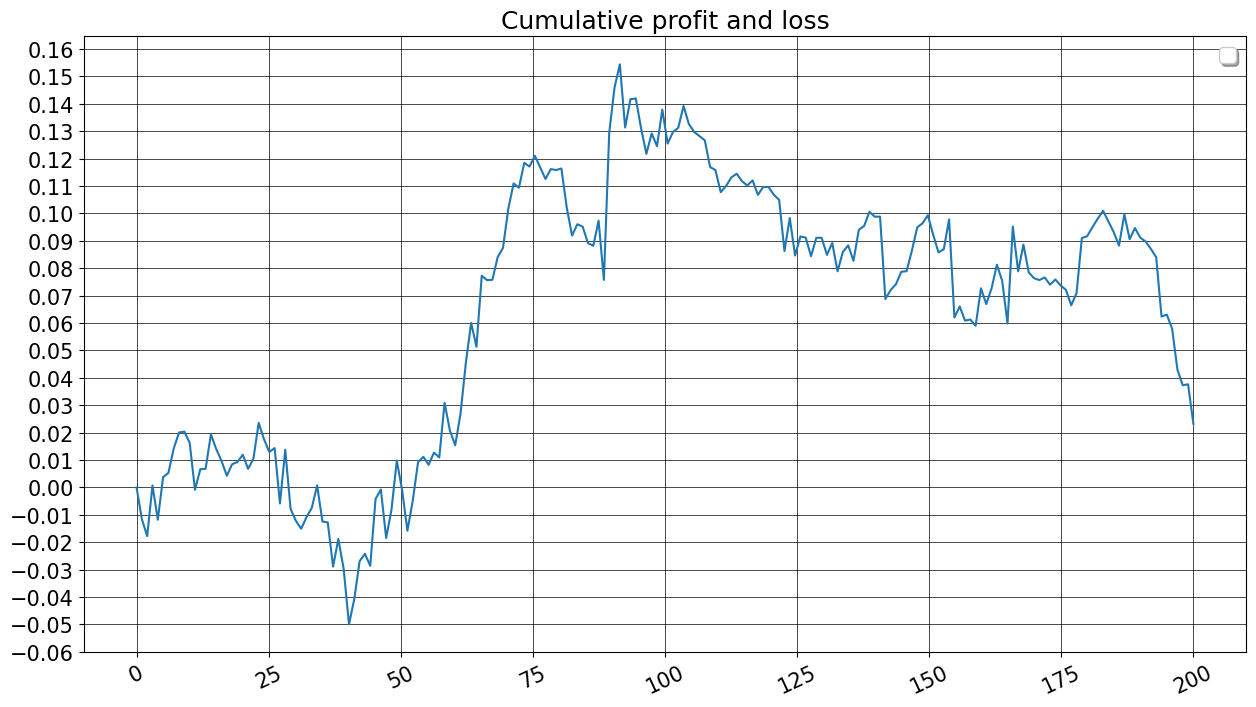

In [12]:
n = 200
show_profit_and_loss(cum_profit_and_loss(data, n, alpha1))